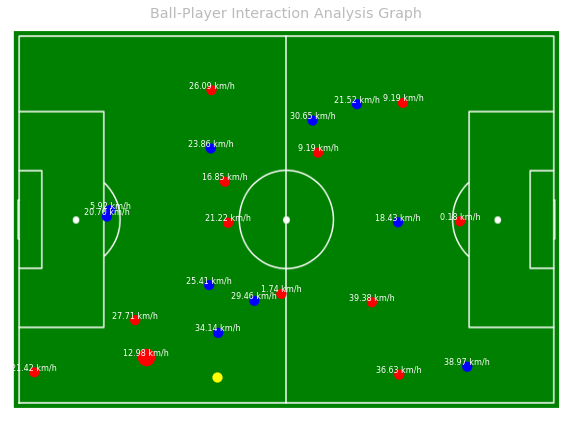

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to create relationship graph from bounding box coordinates
def create_relationship_graph(player_boxes, ball_box):
    G = nx.DiGraph()
    for player_id, player_box in enumerate(player_boxes):
        player_distance = calculate_distance(player_box, ball_box)
        player_speed = calculate_speed()  # Placeholder for calculating player speed
        team_id = player_id // 11  # Assuming alternating jerseys for simplicity
        G.add_node(player_id, bbox=player_box, distance=player_distance, speed=player_speed, team=team_id)
    G.add_node('Ball', bbox=ball_box)
    
    # Identify second closest player to the ball
    sorted_players = sorted(G.nodes(data=True), key=lambda x: x[1].get('distance', float('inf')))
    if len(sorted_players) > 1:
        second_closest_player_id = sorted_players[1][0]
    else:
        second_closest_player_id = None
    
    # Add edges based on spatial relationships
    for player_id, player_box in enumerate(player_boxes):
        if is_close(player_box, ball_box):
            G.add_edge(player_id, 'Ball')
        for other_player_id, other_player_box in enumerate(player_boxes):
            if player_id != other_player_id and is_close(player_box, other_player_box):
                same_team = G.nodes[player_id]['team'] == G.nodes[other_player_id]['team']
                edge_color = 'blue' if same_team else 'red'
                G.add_edge(player_id, other_player_id, color=edge_color)
    
    return G, second_closest_player_id

# Calculate distance between two bounding boxes
def calculate_distance(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    distance = ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5
    return distance

# Placeholder function to calculate player speed
def calculate_speed():
    return np.random.uniform(0, 40)  # Placeholder for generating random player speed

# Function to check if two bounding boxes are close or overlap
def is_close(box1, box2, threshold=0.5):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    intersection_area = max(0, min(x1 + w1, x2 + w2) - max(x1, x2)) * max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    union_area = w1 * h1 + w2 * h2 - intersection_area
    iou = intersection_area / union_area
    return iou > threshold

# Example bounding box coordinates for players and the ball
player_boxes = []
for _ in range(22):  # For 22 players (11 for each team)
    x = random.uniform(0, 900 - 10)  # Adjusted to ensure players fit within pitch
    y = random.uniform(0, 600 - 10)  # Adjusted to ensure players fit within pitch
    w = random.uniform(10, 30)  # Random width
    h = random.uniform(10, 30)  # Random height
    player_boxes.append((x, y, w, h))

# Example ball bounding box
ball_box = (random.uniform(0, 900 - 10), random.uniform(0, 600 - 10), 10, 10)  # Adjusted to ensure ball fits within pitch

# Create relationship graph
G, second_closest_player_id = create_relationship_graph(player_boxes, ball_box)

# Visualize the graph
plt.figure(figsize=(10, 8))

# Draw soccer pitch background
pitch_width = 700
pitch_length = 1000
plt.imshow(plt.imread('pitch.png'), extent=[0, pitch_length, 0, pitch_width])

# Define node positions for players
pos = {player_id: (box[0] + box[2] / 2, box[1] + box[3] / 2) for player_id, box in enumerate(player_boxes)}
pos['Ball'] = (ball_box[0] + ball_box[2] / 2, ball_box[1] + ball_box[3] / 2)

# Draw edges between players of the same team
same_team_edges = [(u, v) for u, v, d in G.edges(data=True) if d['color'] == 'blue']
nx.draw_networkx_edges(G, pos, edgelist=same_team_edges, edge_color='blue', arrows=True)

# Draw edges between players of different teams
diff_team_edges = [(u, v) for u, v, d in G.edges(data=True) if d['color'] == 'red']
nx.draw_networkx_edges(G, pos, edgelist=diff_team_edges, edge_color='red', arrows=True)

# Draw nodes (players and ball)
team_colors = ['blue' if G.nodes[n]['team'] == 0 else 'red' for n in G.nodes() if n != 'Ball']
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n != 'Ball'], node_color=team_colors, node_size=100)
nx.draw_networkx_nodes(G, pos, nodelist=['Ball'], node_color='yellow', node_size=100)

# Add speed information as labels
speed_labels = {player_id: f'{G.nodes[player_id]["speed"]:.2f} km/h' for player_id in G.nodes() if player_id != 'Ball'}
nx.draw_networkx_labels(G, pos, labels=speed_labels, font_size=8, font_color='white', verticalalignment='bottom')

# Highlight the player holding the ball
if second_closest_player_id is not None:
    nx.draw_networkx_nodes(G, pos, nodelist=[second_closest_player_id], node_color='red', node_size=300)

plt.title('Ball-Player Interaction Analysis Graph')
plt.axis('off')
plt.show()